# Spooky Author Identification: Bag-of-Words MLP Model

## Implementation

### Import packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '' # Set to empty string for CPU, '0' for the first GPU

In [3]:
# If you don't already have these packages, run this cell
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from packages import *

Using TensorFlow backend.


In [5]:
MODEL_NAME = 'bow_mlp'

INPUT_DIR = '../input/'
TRAIN_FILE_PATH = f'{INPUT_DIR}train.csv'
TEST_FILE_PATH = f'{INPUT_DIR}test.csv'
SAMPLE_SUBMISSION_FILE_PATH = f'{INPUT_DIR}sample_submission.csv'

OUTPUT_DIR = '../output/'
OUTPUT_LOGS_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/logs/'
OUTPUT_MODELS_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/models/'
OUTPUT_SCORES_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/scores/'
OUTPUT_SUBMISSIONS_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/submissions/'
OUTPUT_SUMMARIES_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/summaries/'

# Create the output directories if they do not exist (the `_` is necessary
# in order to create intermediate directories and is itself not created)
os.makedirs(os.path.dirname(f'{OUTPUT_LOGS_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_MODELS_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_SCORES_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_SUBMISSIONS_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_SUMMARIES_DIR}_'), exist_ok=True)

MAX_FEATURES = 20000 # The max number of features (unigrams and bigrams)
TOKEN_MODE = 'word' # Word-level tokenization; can also be set to 'char'
NGRAM_RANGE = (1, 2) # Range of n-gram sizes (unigrams and bigrams)
# A token will be discarded if it appears less than 2 times across documents in the corpus
MIN_DOCUMENT_FREQUENCY = 2
N_SPLITS = 10

# Fix a random seed for reproducibility
SEED = 42
np.random.seed(SEED)

### Load data

In [6]:
train, test, submission = load_data(TRAIN_FILE_PATH,
                                    TEST_FILE_PATH,
                                    SAMPLE_SUBMISSION_FILE_PATH)

### Google's "Algorithm for Data Preparation and Model Building"

Let's follow Google's algorithm below to test our hypothesis that a bag-of-words multilayer perceptron model will perform better than our CNN and RNN models using pre-trained GloVe and fastText word embeddings.

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2-5

```
1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a
simple multi-layer perceptron (MLP) model to classify them (left branch in the
flowchart below):
  a. Split the samples into word n-grams; convert the n-grams into vectors.
  b. Score the importance of the vectors and then select the top 20K using the scores.
  c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a
   sepCNN model to classify them (right branch in the flowchart below):
  a. Split the samples into words; select the top 20K words based on their frequency.
  b. Convert the samples into word sequence vectors.
  c. If the original number of samples/number of words per sample ratio is less
     than 15K, using a fine-tuned pre-trained embedding with the sepCNN
     model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.
```

### Calculate the number of samples/number of words per sample ratio
From the same source URL above, Google has stated the following:

> **From our experiments, we have observed that the ratio of “number of samples” (S) to “number of words per sample” (W) correlates with which model performs well.**

> When the value for this ratio is small (<1500), small multi-layer perceptrons that take n-grams as input (which we'll call **Option A**) perform better or at least as well as sequence models. MLPs are simple to define and understand, and they take much less compute time than sequence models. When the value for this ratio is large (>= 1500), use a sequence model (**Option B**).


We have calculated that this number is about `732.46` from the EDA notebook.

### Tokenize the text as word n-grams and convert them into vectors
Since the calculated ratio of `732.46` is less than the `1500` threshold, we'll proceed with **Option A** (the n-gram inputs with an MLP model). First, we need to tokenize the text as n-grams and select only the top `MAX_FEATURES` most important features from the vector of tokens.

### Preprocess text

In [7]:
# The target classes need to be converted to integers so that
# EAP --> 0
# HPL --> 1
# MWS --> 2
y_train_integers = integer_encode_classes(train['author'].values)

Original class labels: ['EAP' 'HPL' 'MWS']


In [8]:
# The target classes need to be one-hot encoded so that
# EAP --> 0 --> [1, 0, 0]
# HPL --> 1 --> [0, 1, 0]
# MWS --> 2 --> [0, 0, 1]
y_train_encoded = one_hot_encode_classes(y_train_integers)

In [9]:
# Apply text preprocessing on each sentence
X_train_sequences = list(train['text'].apply(
    lambda x: process_text(x,
                           lower=False,
                           remove_punc=False,
                           normalize_spelling=True, # Todo: Also try False
                           stem=False,
                           lemmatize=False,
                           remove_stopwords=False)).values)
X_test_sequences = list(test['text'].apply(
    lambda x: process_text(x,
                           lower=False,
                           remove_punc=False,
                           normalize_spelling=True, # Todo: Also try False
                           stem=False,
                           lemmatize=False,
                           remove_stopwords=False)).values)

# Vectorize the sentences and TF-IDF features
X_train_tokenized, X_test_tokenized = vectorize_ngrams(X_train_sequences,
                                                       X_test_sequences,
                                                       y_train_integers,
                                                       MAX_FEATURES,
                                                       TOKEN_MODE,
                                                       NGRAM_RANGE,
                                                       MIN_DOCUMENT_FREQUENCY)

Found 76279 unique unigrams and bigrams.
But only kept the 20000 most important ones.


In [10]:
# Retrieve the input shape
input_shape = X_train_tokenized.shape[1:]
input_shape

(20000,)

In [11]:
X_train_tokenized[0:3]

<3x20000 sparse matrix of type '<class 'numpy.float32'>'
	with 119 stored elements in Compressed Sparse Row format>

### Train the model
Each model will be evaluated based on the logloss metric using either 5-fold or 10-fold cross validation; the lower the logloss, the better the model. This is the step in which we measure the model performance with different hyperparameter values to find the best model configuration for the dataset.

In [12]:
# Import model-dependent files
from models import build_model_callbacks, save_model_summary
from models import get_random_mlp_params as get_random_model_params
from models import build_mlp_model as build_model

In [13]:
# Random search

training_num_epochs = 100 # With early stopping in place
num_random_search_iter = 60 # The number of iterations
offset_iter = 0 # How many iterations to offset the nth iteration by

# Calculate the k-fold splits (same splits across all iterations)
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# Randomly search for the best model using 10-fold cross validation for each iteration.
# Note: Before re-running this cell, you might want to delete the existing files in the
# `OUTPUT_SUMMARIES_DIR` folder, since the files within might not get overwritten.
for nth_iter in range(1+offset_iter, num_random_search_iter+1+offset_iter):
    
    # Start the training timer for the current iteration
    training_start = time()
    
    nth_iter_str = f'iter_{nth_iter:02d}'
    print(f'\n----- Iteration {nth_iter} of {num_random_search_iter+offset_iter} -----')

    # Metrics to monitor and record
    monitored_metric = 'val_loss'
    other_metrics = ['val_acc', 'loss', 'acc']
    all_metrics = ['val_loss', 'val_acc', 'loss', 'acc']
    
    # The number of training epochs that have passed at which
    # the best validation loss is recorded
    best_score_num_epochs = []
    
    # The metric scores recorded from the epoch number at which
    # the best validation loss is recorded.
    # Note that each list should be `N_SPLITS` in length.
    best_scores_per_fold = { 'val_loss': [], 'val_acc': [], 'loss': [], 'acc': [] }
    
    # Runtime records
    pred_runtimes = []
    pred_runtime_strs = []

    # Retrieve the random model params for the current iteration
    random_model_params = get_random_model_params()
    batch_size = random_model_params['batch_size']
    
    print('Writing model params to file...')
    params_file_path = f'{OUTPUT_MODELS_DIR}{nth_iter_str}.params.json'
    save_dictionary_to_file(random_model_params, params_file_path)    
    
    # The model summary, improvement log, and classification summary file path
    log_file_path = f'{OUTPUT_LOGS_DIR}{nth_iter_str}.log.txt'
    
    # Prepare the generator
    folds = kfold.split(X_train_tokenized, y_train_integers)
    
    # Begin 10-fold cross validation for the current set of random model params
    for fold, (train_indices, valid_indices) in enumerate(folds):
        nth_fold = fold + 1
        nth_fold_str = f'fold_{nth_fold:02d}'
        print(f'\n----- Fold {nth_fold} of {N_SPLITS} -----')

        # Prepare the splits of data
        X_train, y_train = X_train_tokenized[train_indices], y_train_encoded[train_indices]
        X_valid, y_valid = X_train_tokenized[valid_indices], y_train_encoded[valid_indices]

        # Construct model callbacks, save the best models, and log metrics to file
        logger_file_path = f'{OUTPUT_SCORES_DIR}{nth_iter_str}.{nth_fold_str}.scores.csv'
        model_callbacks = build_model_callbacks(monitored_metric,
                                                'min',
                                                log_file_path, # progress
                                                None, # model
                                                logger_file_path, # logger
                                                nth_fold,
                                                N_SPLITS)
        # Build the model
        model = build_model(input_shape, random_model_params)
        # Save the model summary to file on the first fold only
        # since the models are identical across folds
        if nth_fold == 1:
            save_model_summary(model, log_file_path)
        
        # Train the model
        history = model.fit(X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=training_num_epochs,
                            verbose=1,
                            callbacks=model_callbacks,
                            validation_data=[X_valid, y_valid],
                            shuffle=True)
        
        # Save the scores for later evaluation
        monitored_metric_fold_scores = history.history[monitored_metric]
        # Save only the best validation loss
        epoch_index = np.argmin(monitored_metric_fold_scores)
        best_score_num_epochs.append(int(epoch_index + 1))
        best_monitored_metric_score = monitored_metric_fold_scores[epoch_index]
        best_scores_per_fold[monitored_metric].append(best_monitored_metric_score)

        for metric in other_metrics:
            other_metric_fold_scores = history.history[metric]
            # Save only the corresponding current metric score for the
            # best validation loss epoch
            same_epoch_score = other_metric_fold_scores[epoch_index]
            best_scores_per_fold[metric].append(same_epoch_score)

        # Construct a classification report and confusion matrix
        print('Making predictions...')
        pred_start = time()
        y_pred = model.predict(X_valid, batch_size=batch_size, verbose=0)
        pred_elapsed, pred_elapsed_str = get_time_elapsed(pred_start)
        pred_runtimes.append(pred_elapsed)
        pred_runtime_strs.append(pred_elapsed_str)

        print('Writing classification summary to file...')
        save_classification_summary(y_valid,
                                    y_pred,
                                    [0, 1, 2],
                                    ['EAP', 'HPL', 'MWS'],
                                    log_file_path,
                                    mode='a')

    print('Writing CV results and runtime summary to file...')
    # Calculate the mean and standard deviation across all folds' best scores
    summary_lines = 'CV Results Summary:'
    for metric in all_metrics:
        mean = np.mean(best_scores_per_fold[metric])
        std = np.std(best_scores_per_fold[metric])
        summary_lines += f'\n- {metric} mean and std: {mean:.5f} (+/- {std:.5f})'
    monitored_mean = np.mean(best_scores_per_fold[monitored_metric])
    summary_file_path = (f'{OUTPUT_SUMMARIES_DIR}{monitored_mean:.5f}.'
                         f'{nth_iter_str}.summary.txt')
    
    # Calculate the suggested number of epochs to train for
    # using the entire training dataset
    final_num_epochs = np.mean(best_score_num_epochs)
    # We take the ceiling because it's better to train for
    # a little longer than to underfit
    final_num_epochs = int(np.ceil(final_num_epochs))
    summary_lines += f'\n\nfinal_num_epochs = {final_num_epochs}\n\n'
    
    # Save the best epochs per fold
    best_epochs_str = json.dumps(best_score_num_epochs)
    summary_lines += f'best_score_num_epochs = {best_epochs_str}\n\n'
    
    # Save the best scores per fold
    best_scores_str = json.dumps(best_scores_per_fold, indent=4)
    summary_lines += f'best_scores_per_fold = {best_scores_str}\n\n'
    
    # Calculate the total and average runtimes across all folds
    training_elapsed, training_elapsed_str = get_time_elapsed(training_start)
    training_fold_elapsed_str = format_time_str(training_elapsed / N_SPLITS)
    pred_elapsed = np.sum(pred_runtimes)
    pred_elapsed_str = format_time_str(pred_elapsed)
    pred_fold_elapsed_str = format_time_str(pred_elapsed / N_SPLITS)
    summary_lines += (f'Total stratified {N_SPLITS}-fold loop runtime: '
                      f'{training_elapsed_str}\n'
                      f'Average training runtime per fold: '
                      f'{training_fold_elapsed_str}\n\n'
                      f'Total stratified {N_SPLITS}-fold prediction runtime: '
                      f'{pred_elapsed_str}\n'
                      f'Average prediction runtime per fold: '
                      f'{pred_fold_elapsed_str}\n')
    for f, time_str in enumerate(pred_runtime_strs):
        summary_lines += f'\nFold {f + 1} prediction runtime: {time_str}'
    
    save_line_to_file(summary_lines, summary_file_path, 'w')



----- Iteration 1 of 1 -----
Writing model params to file...

----- Fold 1 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/1000
17620/17620 [==============================] - 12s 665us/step - loss: 0.9187 - acc: 0.6241 - val_loss: 0.6860 - val_acc: 0.8188
Epoch 2/1000
17620/17620 [==============================] - 12s 696us/step - loss: 0.5061 - acc: 0.8631 - val_loss: 0.4367 - val_acc: 0.8581
Epoch 3/1000
17620/17620 [==============================] - 12s 705us/step - loss: 0.3234 - acc: 0.9064 - val_loss: 0.3523 - val_acc: 0.8765
Epoch 4/1000
17620/17620 [==============================] - 9s 538us/step - loss: 0.2478 - acc: 0.9261 - val_loss: 0.3115 - val_acc: 0.8836
Epoch 5/1000
17620/17620 [==============================] - 11s 615us/step - loss: 0.1952 - acc: 0.9430 - val_loss: 0.2902 - val_acc: 0.8887
Epoch 6/1000
17620/17620 [==============================] - 10s 577us/step - loss: 0.1664 - acc: 0.9483 - val_loss: 0.2779 - val_acc: 0.8954
Epoch 7/1000
17620

17621/17621 [==============================] - 8s 478us/step - loss: 0.1946 - acc: 0.9427 - val_loss: 0.2478 - val_acc: 0.9142
Epoch 6/1000
17621/17621 [==============================] - 8s 475us/step - loss: 0.1647 - acc: 0.9499 - val_loss: 0.2361 - val_acc: 0.9142
Epoch 7/1000
17621/17621 [==============================] - 8s 472us/step - loss: 0.1446 - acc: 0.9559 - val_loss: 0.2301 - val_acc: 0.9142
Epoch 8/1000
17621/17621 [==============================] - 9s 483us/step - loss: 0.1218 - acc: 0.9652 - val_loss: 0.2268 - val_acc: 0.9147
Epoch 9/1000
17621/17621 [==============================] - 8s 465us/step - loss: 0.1093 - acc: 0.9671 - val_loss: 0.2270 - val_acc: 0.9173
Epoch 10/1000
17621/17621 [==============================] - 8s 466us/step - loss: 0.0990 - acc: 0.9694 - val_loss: 0.2285 - val_acc: 0.9162
Epoch 11/1000
17621/17621 [==============================] - 8s 462us/step - loss: 0.0892 - acc: 0.9734 - val_loss: 0.2309 - val_acc: 0.9152
Epoch 00011: early stopping
Mak

17622/17622 [==============================] - 8s 458us/step - loss: 0.0907 - acc: 0.9729 - val_loss: 0.2397 - val_acc: 0.9055
Epoch 12/1000
17622/17622 [==============================] - 8s 456us/step - loss: 0.0832 - acc: 0.9751 - val_loss: 0.2403 - val_acc: 0.9070
Epoch 00012: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 10 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/1000
17622/17622 [==============================] - 9s 495us/step - loss: 0.9076 - acc: 0.6185 - val_loss: 0.6550 - val_acc: 0.8416
Epoch 2/1000
17622/17622 [==============================] - 9s 503us/step - loss: 0.5026 - acc: 0.8649 - val_loss: 0.3991 - val_acc: 0.8815
Epoch 3/1000
17622/17622 [==============================] - 8s 477us/step - loss: 0.3266 - acc: 0.9039 - val_loss: 0.3130 - val_acc: 0.8942
Epoch 4/1000
17622/17622 [==============================] - 9s 486us/step - loss: 0.2450 - acc: 0.9269 - val_loss: 0.2743 - val_acc: 0.8998
Epoc

### Evaluate the results

In [27]:
# Set these variables to an existing output file
nth_iter = 1
nth_fold = 7
iter_fold_scores = pd.read_csv(f'{OUTPUT_SCORES_DIR}iter_{nth_iter:02d}.'
                               f'fold_{nth_fold:02d}.scores.csv')

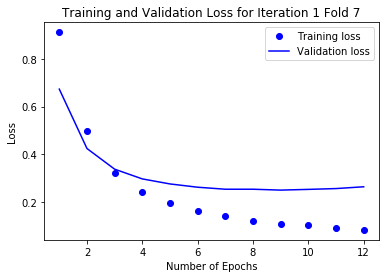

In [28]:
# Pass in a metric (without the `val_` prefix) and a fold index to show
# the training and validation error curves over the number of epochs
display_metric_vs_epochs_plot(iter_fold_scores, 'loss', nth_iter, nth_fold)

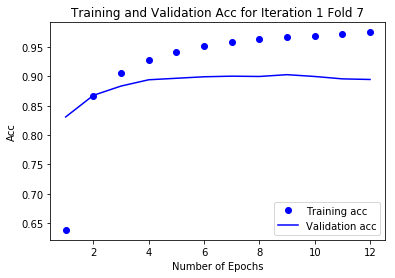

In [29]:
display_metric_vs_epochs_plot(iter_fold_scores, 'acc', nth_iter, nth_fold)

### Make predictions on the test data
In order to make predictions on the Kaggle-provided unlabeled test data, we will need to submit our predictions to Kaggle. It would be best to train on the entire training set; this means that, this time, we won't provide a validation set to the Keras model.

How do we know how many epochs to train for? To figure this out, we can use the results from the cross validation phase. Since we have recorded the number of epochs that each fold took to train the model before stopping, we can take the average number of epochs across all folds and use that as the number of epochs to train our final model.

#### Train the model

In [30]:
# Set this to the best number of epochs based on the evaluation phase
final_num_epochs = 9

In [31]:
# Select the best model params based on the evaluation phase
best_iter = 1
final_model_params = load_dictionary_from_file(f'{OUTPUT_MODELS_DIR}'
                                               f'iter_{best_iter:02d}.params.json')
final_batch_size = final_model_params['batch_size']

In [32]:
# Build the model with the best model params
model = build_model(input_shape, final_model_params)
# Save the model architecture, weights, and optimizer state to file
model.save(f'{OUTPUT_MODELS_DIR}final.model.hdf5')
# Save the model summary to file
save_model_summary(model, f'{OUTPUT_SUMMARIES_DIR}final.model_summary.txt')

In [33]:
# Train the model
history = model.fit(X_train_tokenized,
                    y_train_encoded,
                    batch_size=final_batch_size,
                    epochs=final_num_epochs,
                    verbose=1,
                    shuffle=True)

Epoch 1/9
19579/19579 [==============================] - 11s 567us/step - loss: 0.8891 - acc: 0.6574
Epoch 2/9
19579/19579 [==============================] - 11s 578us/step - loss: 0.4625 - acc: 0.8723
Epoch 3/9
19579/19579 [==============================] - 11s 545us/step - loss: 0.3081 - acc: 0.9038
Epoch 4/9
19579/19579 [==============================] - 11s 538us/step - loss: 0.2325 - acc: 0.9290
Epoch 5/9
19579/19579 [==============================] - 10s 534us/step - loss: 0.1875 - acc: 0.9434
Epoch 6/9
19579/19579 [==============================] - 10s 536us/step - loss: 0.1556 - acc: 0.9511
Epoch 7/9
19579/19579 [==============================] - 10s 528us/step - loss: 0.1378 - acc: 0.9577
Epoch 8/9
19579/19579 [==============================] - 10s 535us/step - loss: 0.1181 - acc: 0.9643
Epoch 9/9
19579/19579 [==============================] - 11s 570us/step - loss: 0.1079 - acc: 0.9660


#### Make predictions on the test data

In [34]:
predictions = model.predict(X_test_tokenized, batch_size=final_batch_size, verbose=1)

8392/8392 [==============================] - 1s 98us/step


In [35]:
# Check the final submission values
predictions[0:3]

array([[2.3719482e-03, 1.8796196e-02, 9.7883189e-01],
       [9.9660289e-01, 3.2997099e-03, 9.7403281e-05],
       [7.0439349e-03, 9.7891653e-01, 1.4039552e-02]], dtype=float32)

#### Create a submission CSV

In [36]:
submission[['EAP', 'HPL', 'MWS']] = predictions
submission_num = 30
submission_description = 'bow_google_mlp_after_tp_i'
submission_filename = f'{submission_num:03d}_{submission_description}.csv'
submission_file_path = f'{OUTPUT_SUBMISSIONS_DIR}{submission_filename}'
submission.to_csv(submission_file_path, index=False)

### Evaluate the mean logloss of the Kaggle submission
After submitting to Kaggle, we can calculate the mean logloss across the entire test dataset as follows:
```
Given:
    n_test = 8392
    %_private = 0.7
    %_public = 0.3
    private_logloss # Retrieve from Kaggle after submission
    public_logloss # Retrieve from Kaggle after submission
    
Mean logloss = (private_logloss * n_private + public_logloss * n_public) / n_test
             = (private_logloss * (%_private * n_test)
                + public_logloss * (%_public * n_test))
               / n_test
               
Where n_test = n_private + n_public
```

#### Benchmark Model
Our benchmark model is the sample submission file provided by Kaggle, in which the probability distribution across the three authors is the exact same per sample, such that their probabilities are proportional to the number of samples of said author's work in the training dataset (EAP at about 40%, HPL at about 29%, and MWS at about 31%).

In [37]:
n_test = len(submission)
n_private = n_test * 0.7
n_public = n_test * 0.3
print(f'Total number of samples: {n_test}',
      f'Number of private leaderboard samples: {n_private}',
      f'Number of public leaderboard samples: {n_public}',
      sep='\n')

Total number of samples: 8392
Number of private leaderboard samples: 5874.4
Number of public leaderboard samples: 2517.6


In [38]:
private_logloss = 1.09094
public_logloss = 1.08199
mean_logloss = (private_logloss * n_private + public_logloss * n_public) / n_test
print(f'Mean logloss for the benchmark model: {mean_logloss}')

Mean logloss for the benchmark model: 1.088255


#### CNN Model

In [39]:
calculate_mean_logloss(0.36698, 0.38822)

Mean logloss: 0.37335
